In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
# Get the filenames of all images in the folder
file_names = os.listdir("data")

# Store the filenames of cat and dog images separately
cat_images = []
dog_images = []

# Determine whether the image is a cat or a dog based on the filename prefix, and add the filename to the corresponding list
for file_name in file_names:
    if file_name.startswith("cat"):
        cat_images.append(file_name)
    elif file_name.startswith("dog"):
        dog_images.append(file_name)

# Combine the image filenames with their corresponding labels to form the dataset
X = cat_images + dog_images
y = ["cat"] * len(cat_images) + ["dog"] * len(dog_images)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=20000, test_size=5000, random_state=42, shuffle=True, stratify=y
)

# Print the size of the training set and test set
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# Print the number of cats and dogs in y_test
print("Number of cats in the training set:", y_train.count("cat"))
print("Number of dogs in the training set:", y_train.count("dog"))


Training set size: 20000
Test set size: 5000
Number of cats in the training set: 10000
Number of dogs in the training set: 10000


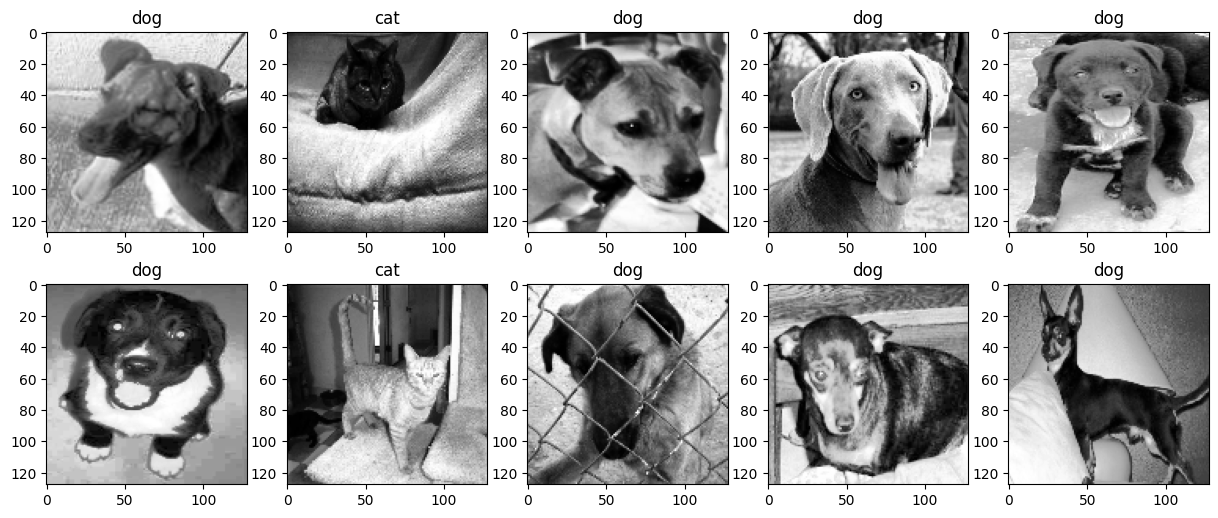

In [6]:
def preprocess(image_file):
    target_size = (128, 128)
    image_path = os.path.join("data", image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.equalizeHist(image)
    return cv2.resize(image, target_size)

# Display 10 images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    x = preprocess(X_train[i])
    axs[i//5, i%5].imshow(x, cmap="gray")
    axs[i//5, i%5].set_title(y_train[i])


In [7]:
X_train_features = []
X_test_features = []

# Extract features from the training set
for file_name in tqdm(X_train):
    image = preprocess(file_name)
    hog_features = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2), block_norm='L2-Hys')
    X_train_features.append(hog_features)

# Extract features from the test set
for file_name in tqdm(X_test):
    image = preprocess(file_name)
    hog_features = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(2, 2), block_norm='L2-Hys')
    X_test_features.append(hog_features)

print("Maximum number of features:", max(len(x) for x in X_train_features))
print("Minimum number of features:", min(len(x) for x in X_train_features))

100%|██████████| 5000/5000 [00:18<00:00, 271.94it/s]


Fitting 3 folds for each of 3 candidates, totalling 9 fits
best K are:     10
KNN Accuracy:   0.62
KNN Precision:  0.82
KNN Recall:     0.3
KNN F1:         0.44


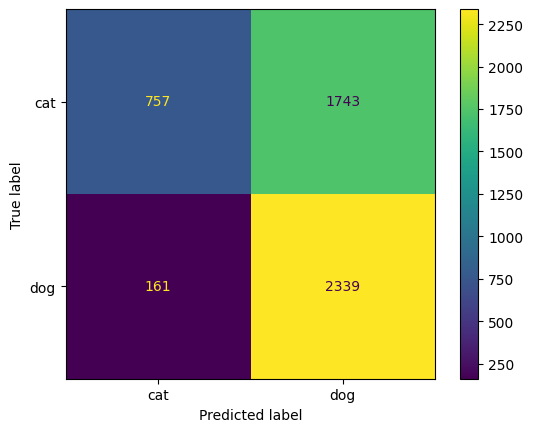

In [13]:
# KNeighbors Classifier

# Train KNN model
k_range = {"n_neighbors": [9, 10, 11]}
knn = KNeighborsClassifier()
gridKNN = GridSearchCV(knn, param_grid=k_range, cv=3, n_jobs=-1, verbose=1)
gridKNN.fit(X_train_features, y_train)

# Predict test set
y_pred = gridKNN.predict(X_test_features)

# Print report
print("best K are:    ", gridKNN.best_params_["n_neighbors"])
print("KNN Accuracy:  ", round(metrics.accuracy_score(y_test, y_pred), 2))
print(
    "KNN Precision: ",
    round(metrics.precision_score(y_test, y_pred, pos_label="cat"), 2),
)
print(
    "KNN Recall:    ", round(metrics.recall_score(y_test, y_pred, pos_label="cat"), 2)
)
print("KNN F1:        ", (round(metrics.f1_score(y_test, y_pred, pos_label="cat"), 2)))

# Print confusion matrix of the model
cm = metrics.confusion_matrix(y_test, y_pred)
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=["cat", "dog"])
cmd.plot()

Fitting 3 folds for each of 6 candidates, totalling 18 fits


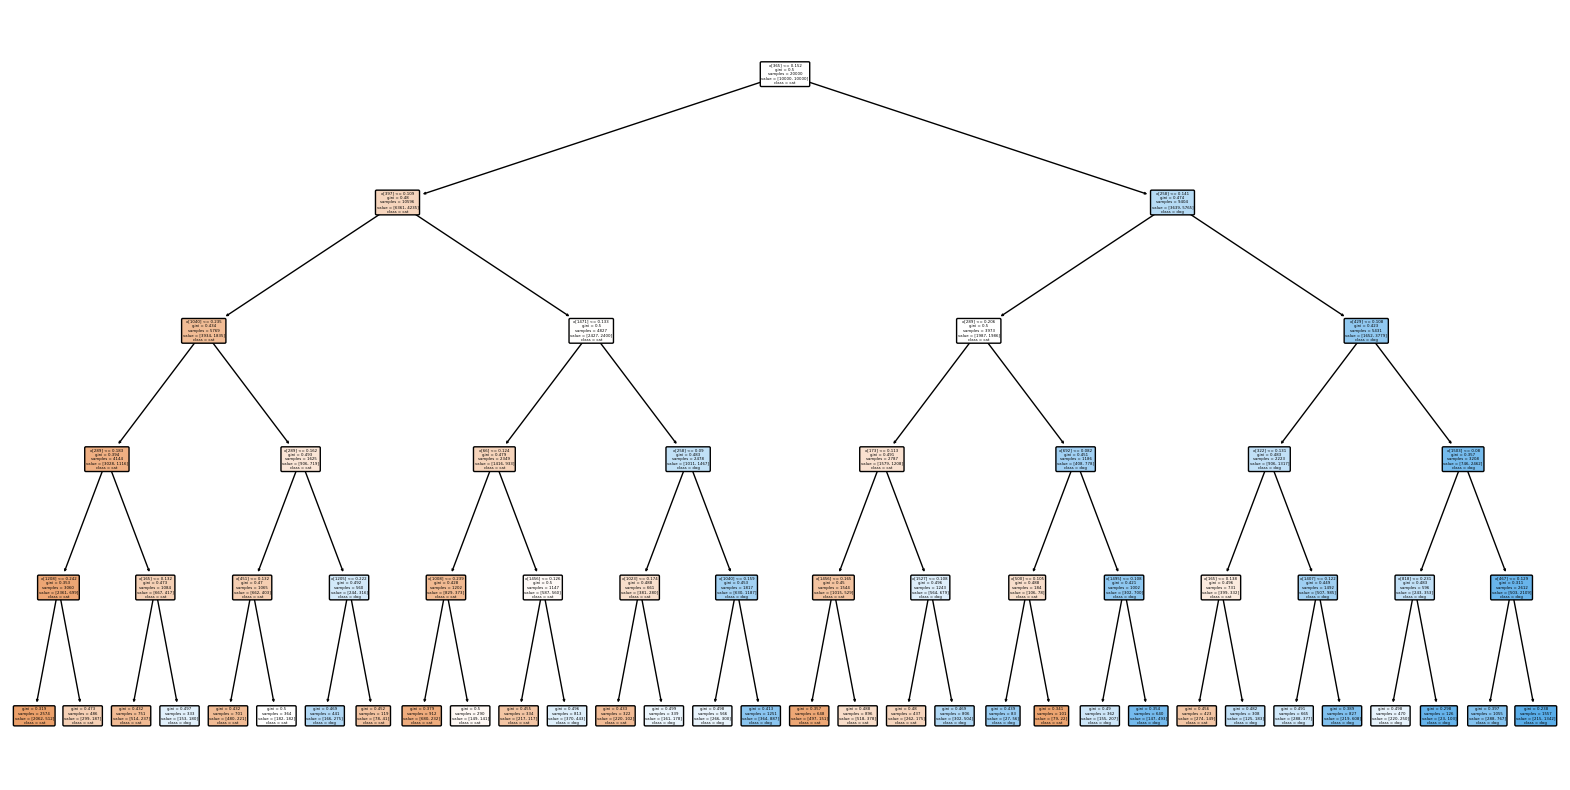

best max_depth:  5
best criterion:  gini
DT Accuracy:   0.66
DT Precision:  0.68
DT Recall:     0.61
DT F1:         0.64


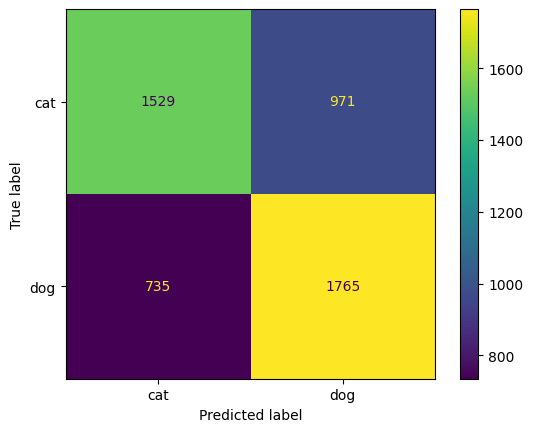

In [20]:
# Decision Tree Classifier

# Define parameter ranges
param_grid = {"max_depth": [3, 5, 7], "criterion": ["entropy", "gini"]}

# Instantiate decision tree classifier
dt = DecisionTreeClassifier()

# Instantiate GridSearchCV
gridDT = GridSearchCV(dt, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Train decision tree model
gridDT.fit(X_train_features, y_train)

# Predict test set
y_pred = gridDT.predict(X_test_features)

# Visualize decision tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(
    gridDT.best_estimator_, filled=True, rounded=True, class_names=["cat", "dog"], ax=ax
)
plt.show()

# Print report
print("best max_depth: ", gridDT.best_params_["max_depth"])
print("best criterion: ", gridDT.best_params_["criterion"])
print("DT Accuracy:  ", round(metrics.accuracy_score(y_test, y_pred), 2))
print(
    "DT Precision: ", round(metrics.precision_score(y_test, y_pred, pos_label="cat"), 2)
)
print("DT Recall:    ", round(metrics.recall_score(y_test, y_pred, pos_label="cat"), 2))
print("DT F1:        ", (round(metrics.f1_score(y_test, y_pred, pos_label="cat"), 2)))

# Print confusion matrix of the model
cm = metrics.confusion_matrix(y_test, y_pred)
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=["cat", "dog"])
cmd.plot()

Fitting 3 folds for each of 3 candidates, totalling 9 fits
best loss:      log_loss
SGD Accuracy:   0.73
SGD Precision:  0.78
SGD Recall:     0.64
SGD F1:         0.7


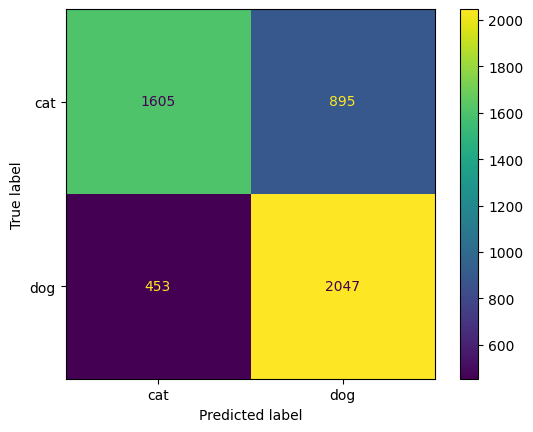

In [21]:
# SGD Classifier

# Define parameter ranges
param_grid = {"loss": ["hinge", "log_loss", "modified_huber"]}

# Instantiate SGD classifier
sgd = SGDClassifier()

# Instantiate GridSearchCV
gridSGD = GridSearchCV(sgd, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Train SGD model
gridSGD.fit(X_train_features, y_train)

# Predict test set
y_pred = gridSGD.predict(X_test_features)

# Print report
print("best loss:     ", gridSGD.best_params_["loss"])
print("SGD Accuracy:  ", round(metrics.accuracy_score(y_test, y_pred), 2))
print(
    "SGD Precision: ",
    round(metrics.precision_score(y_test, y_pred, pos_label="cat"), 2),
)
print(
    "SGD Recall:    ", round(metrics.recall_score(y_test, y_pred, pos_label="cat"), 2)
)
print("SGD F1:        ", (round(metrics.f1_score(y_test, y_pred, pos_label="cat"), 2)))

# Print confusion matrix of the model
cm = metrics.confusion_matrix(y_test, y_pred)
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=["cat", "dog"])
cmd.plot()

- **In the image preprocessing stage I uniformly converted to grayscale images and used equalizeHist for  preprocessing, and resized the resolution to 128*128.**

- **In the next step I simply used the HOG feature extractor. Although this is much better than the raw pixel position information as features. However, for complex image data (e.g. cat and dog images), it may not capture rich enough feature information.**

- **The best score on the dog-cat competition leaderboard was 98%, while my best score was only 73%.**

- **It is possible that the use of convolutional neural networks (CNN) can automatically learn higher-level feature representations from images and therefore perform better on classification tasks. kNN, DT and SGD, although all common machine learning algorithms, may have relatively low performance in handling image classification tasks. In contrast, CNN models are widely used for image classification tasks and have a stronger representation learning capability.**
